In [2]:
import pandas as pd

In [3]:
def extract_elof_genes(row):
    if (row['pLI'] > 0.9
            and row['oe_lof_upper'] < 0.35
            and row['pHaplo'] > 0.86):
        return True
    else:
        return False 

### Bulk data for gene scores
gnomadcons = '../../resources/gnomad.v2.1.1.lof_metrics.by_gene.txt'
phaploscores = '../../resources/Collins_rCNV_2022.dosage_sensitivity_scores.tsv.gz'
clingen_hi_list = '../../resources/ClinGen_haploinsufficiency_gene_GRCh37.bed'
canonlist = '../CanonicalTranscripts_COMP/CanonicalTranscripts.exoncount.tsv'
clingen_lof = '../../resources/ClinGenLoF_genes.txt'

### Lodading canonical transcripts
canon = pd.read_table(canonlist, sep='\t', header=0)
canon_set = set(canon['ENST'])

### Loading bulk files
higene = pd.read_csv(clingen_hi_list, sep='\t', header=None, skiprows=1,
                     names=['CHROM', 'start', 'end', 'gene', 'HIscore']) 
gnomad = pd.read_csv(gnomadcons, sep='\t', header=0, 
                     usecols=['gene', 'pLI', 'oe_lof_upper', 
                              'transcript', 'cds_length']) 
phaplo = pd.read_csv(phaploscores, sep='\t', header=None, skiprows=1,
                     names=['gene', 'pHaplo', 'pTriplo'], compression='infer') 
clingn = pd.read_csv(clingen_lof, sep='\t', header=None, skiprows=1,
                     names=['gene', 'pLI', 'RefSeq', 
                            'SpliceAcceptor', 'SpliceDonor']) 

### Extracct columns
phaplo = phaplo[['gene', 'pHaplo']]

### Merge
gnomad = pd.merge(gnomad, phaplo, how='left',
                  left_on='gene', right_on='gene')

### Canonical ENST mapping
gnomad['is_canon'] = gnomad['transcript'].apply(
    lambda x: True if x in canon_set else False)

### Select estimated Loss of Function genes
gnomad['is_eLoF'] = gnomad.apply(extract_elof_genes, axis=1)

#### Extract non-canonical ENST and shorter cds transcript from duplicated genes
gnomad = gnomad.loc[(gnomad['transcript'] != 'ENST00000368073')] 
gnomad = gnomad.loc[(gnomad['transcript'] != 'ENST00000608209')] 

### G2P data
dd = './G2P_resources/DDG2P.csv.gz'
eye = './G2P_resources/EyeG2P.csv.gz'
skin = './G2P_resources/SkinG2P.csv.gz'
cancer = './G2P_resources/CancerG2P.csv.gz'
cardiac = './G2P_resources/CardiacG2P.csv.gz'
skeletal = './G2P_resources/SkeletalG2P.csv.gz'

### Loading
dddf = pd.read_csv(dd, sep=',', header=0, compression='infer')
eyedf = pd.read_csv(eye, sep=',', header=0, compression='infer')
skidf = pd.read_csv(skin, sep=',', header=0, compression='infer')
candf = pd.read_csv(cancer, sep=',', header=0, compression='infer')
cardf = pd.read_csv(cardiac, sep=',', header=0, compression='infer')
skedf = pd.read_csv(skeletal, sep=',', header=0, compression='infer')
dfs = [dddf, eyedf, skidf, candf, cardf, skedf]

rename_cols = {
    'gene symbol': 'gene',
    'prev symbols': 'prev_symbols', 
    'hgnc id': 'hgnc_id',
    'gene mim': 'gene_mim', 
    'mutation consequence': 'mutation_consequence',
    'confidence category': 'confidence_category',
    'allelic requirement': 'allelic_requirement', 
    'disease name': 'disease_name'
    }

pickup_cols = [
    'gene', 'prev_symbols', 'hgnc_id', 'gene_mim', 
    'mutation_consequence', 'confidence_category', 
    'allelic_requirement', 'panel', 'disease_name', 
    'g2pLoF', 'definitiveFILTER', 'strongFILTER','moderateFILTER'
    ]

def extract_g2pLoF_genes(x):
    if 'absent gene product' in x:
        return 'PASS'
    else:
        return '.'

def extract_definitive(x):
    if x == 'definitive':
        return 'PASS'
    else:
        return '.'

def extract_strong(x):
    if (x == 'definitive' or x == 'strong'):
        return 'PASS'
    else:
        return '.'

def extract_moderate(x):
    if (x == 'definitive' or x == 'strong' or x == 'moderate'):
        return 'PASS'
    else:
        return '.'

for df in dfs:
    df['g2pLoF'] = df['mutation consequence'].apply(extract_g2pLoF_genes)

for df in dfs:
    df['definitiveFILTER'] = df['confidence category'].apply(extract_definitive)
    df['strongFILTER'] = df['confidence category'].apply(extract_strong)
    df['moderateFILTER'] = df['confidence category'].apply(extract_moderate)

### Rename columns
dddf = dddf.rename(columns=rename_cols)
eyedf = eyedf.rename(columns=rename_cols)
skidf = skidf.rename(columns=rename_cols)
candf = candf.rename(columns=rename_cols)
cardf = cardf.rename(columns=rename_cols)
skedf = skedf.rename(columns=rename_cols)

### Extract columns for analysis
dddf = dddf[pickup_cols]
eyedf = eyedf[pickup_cols]
skidf = skidf[pickup_cols]
candf = candf[pickup_cols]
cardf = cardf[pickup_cols]
skedf = skedf[pickup_cols]

### Extract LoF genes
lof_dd = dddf[dddf['g2pLoF'] == 'PASS']
lof_eye = eyedf[eyedf['g2pLoF'] == 'PASS']
lof_ski = skidf[skidf['g2pLoF'] == 'PASS']
lof_can = candf[candf['g2pLoF'] == 'PASS']
lof_car = cardf[cardf['g2pLoF'] == 'PASS']
lof_ske = skedf[skedf['g2pLoF'] == 'PASS']

### Concatnate dataframes
alldf = pd.concat([lof_dd, lof_eye, lof_ski, lof_can, lof_car, lof_ske])

### Fill NaN
alldf.fillna(value='.', inplace=True)

### Check null in "gene" column
# print(f'null count: {alldf["gene"].isnull().sum()}')

### Extract "definitive" or "strong" genes
alldf_filterd = alldf[alldf['strongFILTER'] == 'PASS']

### Remove duplicated genes
alldf_filterd = alldf_filterd.drop_duplicates(subset='gene')

### Summary
ajhg = clingn['gene']
dcpr = alldf_filterd['gene']
hi = higene.loc[higene['HIscore'] == 3, 'gene']
elof = gnomad.loc[gnomad['is_eLoF'] == True, 'gene']

print(f'ClinGen curated genes: {len(ajhg)}')
print(f'DECIPHER genes       : {len(dcpr)}')
print(f'HI genes             : {len(hi)}')
print(f'Estimated LoF genes  : {len(elof)}')

ClinGen curated genes: 1043
DECIPHER genes       : 1830
HI genes             : 347
Estimated LoF genes  : 1851


In [5]:
ajhg.to_csv('./lof_genes_ajhg.txt', header=False, index=False)
dcpr.to_csv('./lof_genes_g2p.txt', header=False, index=False)
hi.to_csv('./lof_genes_hi.txt', header=False, index=False)
elof.to_csv('./lof_genes_elof.txt', header=False, index=False)

!cat ./lof_genes_ajhg.txt ./lof_genes_g2p.txt \
  ./lof_genes_hi.txt ./lof_genes_elof.txt >lof_genes.raw.txt
!sort lof_genes.raw.txt | uniq -c | awk 'BEGIN {OFS="\t"} {print $1, $2}' >lof_genes.txt
!rm -rf ./lof_genes.raw.txt
!cat ./lof_genes.txt | wc -l

3654


In [3]:
import os
import sys
from pathlib import Path

try: 
    __file__
    sys.path.append(os.path.join(os.path.dirname(__file__)))
except NameError:
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '../..'))

from libs import venn

%matplotlib inline

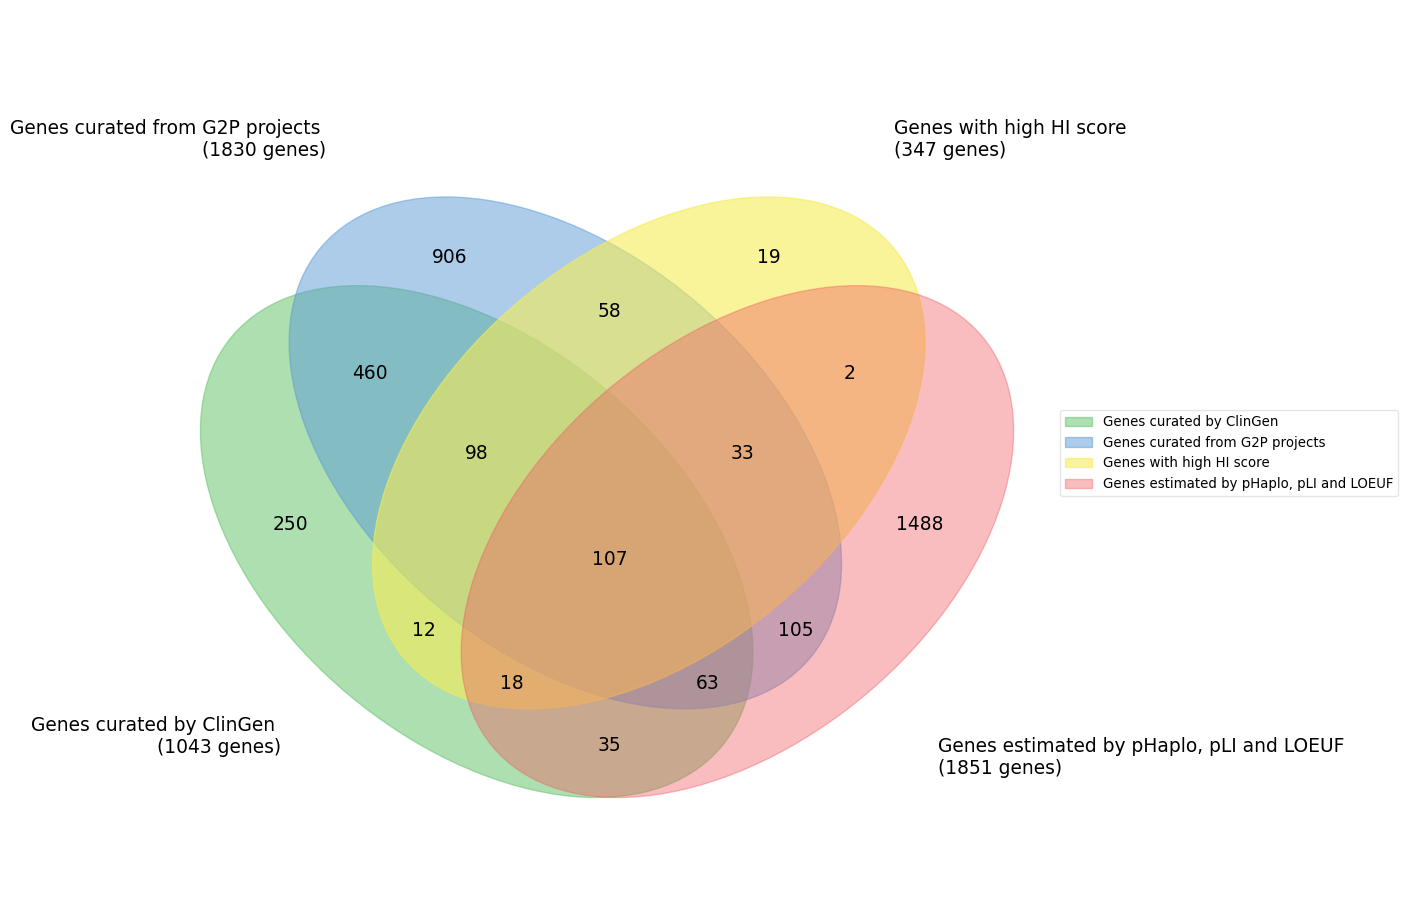

In [4]:
labels = venn.get_labels([ajhg, dcpr, hi, elof], fill=['number'])
fig, ax = venn.venn4(
       labels, 
       names=[f'Genes curated by ClinGen \n({len(ajhg)} genes)',
              f'Genes curated from G2P projects \n({len(dcpr)} genes)',
              f'Genes with high HI score \n({len(hi)} genes)', 
              f'Genes estimated by pHaplo, pLI and LOEUF\n({len(elof)} genes)'
              ],
       leg_names=[
              'Genes curated by ClinGen',
              'Genes curated from G2P projects',
              'Genes with high HI score', 
              'Genes estimated by pHaplo, pLI and LOEUF'
              ]
       )